In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Monte Carlo Simulations

## Problem
We usually have a system (polymers, enzymes, solids, whatever) and some observables $A$ (energy, conformation, reaction rate, etc.) that we'd like to compute on them via averages. You can either compute time-averages from MD or actual experiments or configuration averages via MC. Usually both are the same in the limit large samples ([Ergodicity](https://en.wikipedia.org/wiki/Ergodicity)).

## Configuration Averages
We cannot simply compute $A$ for all the possible configuration and average them, because there will be a lot of them and not all configurations of say polymer will be equally frequent. Highly twisted chains e.g. will be less likely because the energy it takes to realize them will not always be available to the system.

Additionally we know the probability of each configuration will be proportional to $\exp{-\frac{E}{k_B T}}$, the Boltzmann factor, from physics. So instead of picking configurations completely randomly, we would rather sample configuration directly with the correct probability and then do a normal average of our observations.

### Example: Polymer conformation
Let's describe a polymer by a list of bond angles and lengths

In [30]:
def plot_polymer(p):
    x, y = 0, 0
    t = 0
    c = np.random.rand(3)
    for a, b in zip(*p):
        t += a
        dx, dy = b * np.cos(t), b * np.sin(t)
        plt.plot((x, x + dx), (y, y + dy), 'o-', color = c)
        x += dx
        y += dy

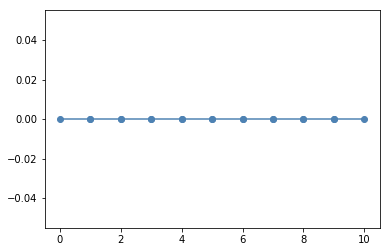

In [32]:
def make_polymer(monomers, bond_length):
    
    p = np.zeros( (2, monomers) )
    p[1, :] = bond_length
    return p

p1 = make_polymer(10, 1.)
plot_polymer(p1)

In [122]:
def energy(polymer, eq_bond = 1, eq_angle = 0, k_bond = 1, k_angle = 1, force = 0):
    angles = polymer[0, :]
    bonds = polymer[1, :]
    energy_bond  = k_bond * sum((bonds - eq_bond)**2)
    energy_angle = k_angle * sum((angles - eq_angle)**2) / np.pi**2
    if abs(force) > 0:
        energy_force = force * end_to_end([polymer])
    else:
        energy_force = 0
    return energy_bond + energy_angle + energy_force

In [47]:
def rand_poly(n):
    o = (np.random.rand(n) - .5) / np.sqrt(n)
    z = np.zeros(n)
    if np.random.rand() < .5:
        return np.array( (np.pi * o, z) )
    else:
        return np.array( (z, o) )

In [71]:
def metropolis(p, T, steps, energy_function = energy):
    p = p.copy()
    e = energy(p)
    ps = np.zeros( (steps,) + p.shape )
    acc = 0
    ps[0] = p
    for i in range(1, steps):
        Δp = rand_poly(p.shape[1])
        Δe = energy_function(p + Δp) - e
        if np.exp(-Δe / T) > np.random.rand():
            p += Δp
            acc += 1
            e += Δe
        ps[i] = p
    
    return ps, acc / steps

In [113]:
def vector(f):
    import functools    
    @functools.wraps(f)
    def ff(xs):
        return np.array([f(x) for x in xs])
    return ff

@vector
def mean_bond(p):
    return p[1].mean()

@vector
def mean_angle(p):
    return p[0].mean()

@vector
def end_to_end(p):
    l = [0, 0]
    angle = 0
    for a, b in p.T:
        angle += a
        l[0] += b * np.cos(angle)
        l[1] += b * np.sin(angle)
    
    return np.sqrt(l[0]**2 + l[1]**2)

In [48]:
p1 = make_polymer(10, 2)

In [110]:
ps, pacc = metropolis(p1, 1, 1000)
print(pacc)

0.848


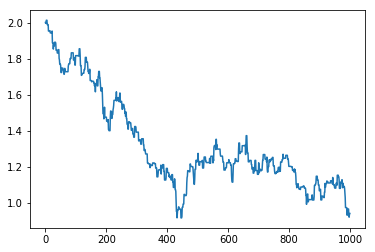

In [111]:
plt.plot(mean_bond(ps))

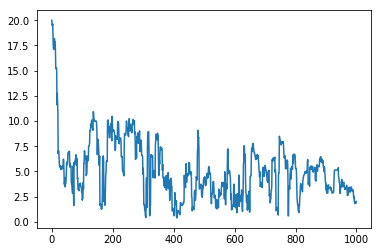

In [114]:
plt.plot(end_to_end(ps))

0.889
0.894
0.903
0.909
0.922


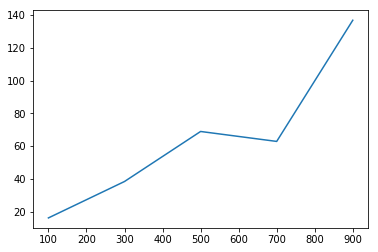

In [115]:
R = []
ns = list(range(100, 1000, 200))
for n in ns:
    p = make_polymer(n, 1)
    ps, acc = metropolis(p, 1, 1000)
    print(np.mean(acc))
    R.append(end_to_end(ps[n//2:]))
    
plt.plot(ns, [Ri.mean() for Ri in R])

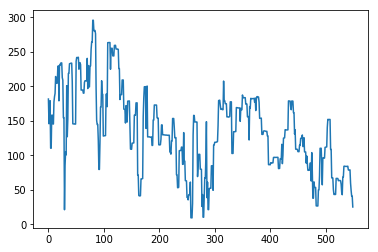

In [116]:
plt.plot(R[-1])

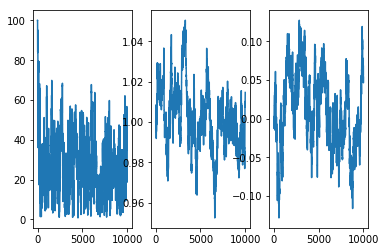

In [119]:
ps, acc = metropolis(make_polymer(100, 1), .1, 10000, energy_function = )
plt.subplot(131)
plt.plot(end_to_end(ps))
plt.subplot(132)
plt.plot(mean_bond(ps))
plt.subplot(133)
plt.plot(mean_angle(ps))

## Entropic Spring

0.9189
0.9054
0.89462
0.88043
0.86564
0.84467
0.67707
0.0
0.0
0.0


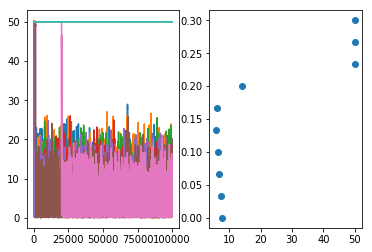

In [124]:
forces = np.linspace(0, .3, 10)
p0 = make_polymer(50, 1)
length = []
plt.subplot(121)
for f in forces:
    ps, acc = metropolis(p0, T = 1, steps = 100000,
                         energy_function = lambda p: energy(p, k_angle = 0, force = f))
    print(acc)
    ls = end_to_end(ps)
    plt.plot(ls)
    length.append(ls.mean())

plt.subplot(122)
plt.plot(length, forces, 'o')